# RCWA Simulation Example: Dielectric Metasurface

This notebook reproduces COMSOL simulation results using a PyTorch-based RCWA implementation.

## Structure
- **Material**: TiO₂ rectangular post (180nm × 100nm, rotated 45°)
- **Substrate**: SiO₂ glass (n = 1.5)
- **Height**: 800 nm
- **Period**: 380 nm
- **Illumination**: Normal incidence (θ=0°), x-polarized

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import time
import sympy

# RCWA simulation package
from clabRCWA import Environment, Incident, RCWA, geometry, utils

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.10.0+cu126
CUDA available: True


In [39]:
def load_comsol_transmission(filename):
    """
    Load transmission coefficients from COMSOL text file.
    
    COMSOL exports complex numbers as strings like "0.5+0.3i".
    This function parses them into numpy complex arrays.
    
    Args:
        filename: Path to COMSOL output file
        
    Returns:
        t_xx, t_xy: Complex transmission coefficients (co-pol and cross-pol)
    """
    # Load columns 1 and 2 as strings, skip 5 header rows
    spectrum = np.loadtxt(filename, usecols=[1, 2], skiprows=5, dtype='str')
    
    def parse_complex_column(col_data):
        """Parse a column of complex number strings."""
        n_points = col_data.shape[0]
        break_points = np.zeros(n_points, dtype='int')
        complex_values = np.zeros(n_points, dtype='complex')
        
        # Find split point between real and imaginary parts
        # Look for + or - that's not part of the exponent or leading sign
        for i in range(n_points):
            for j, char in enumerate(col_data[i]):
                if char == '+' or char == '-':
                    if j == 0:  # Leading sign
                        continue
                    if col_data[i][j-1] == 'E':  # Scientific notation exponent
                        continue
                    break_points[i] = j
                    break
        
        # Parse real and imaginary parts separately
        for i in range(n_points):
            real_part = sympy.sympify(col_data[i][:break_points[i]])
            imag_part = sympy.sympify(col_data[i][break_points[i]:-1])  # Remove trailing 'i'
            complex_values[i] = complex(real_part, imag_part)
        
        return complex_values
    
    # Parse both columns
    t_xx = parse_complex_column(spectrum[:, 0])
    t_xy = parse_complex_column(spectrum[:, 1])
    
    return t_xx, t_xy

In [40]:
# Load COMSOL reference data
comsol_file = 'COMSOL ref.txt'
t_xx_comsol, t_xy_comsol = load_comsol_transmission(comsol_file)

print(f"Loaded {len(t_xx_comsol)} wavelength points from COMSOL")

Loaded 33 wavelength points from COMSOL


## Material Properties

### Materials:
- **TiO₂ (Titanium Dioxide)**: Wavelength-dependent refractive index, Bodurov et al. 2016
- **SiO₂ (Glass)**: n = 1.5
- **Air**: n = 1.0

Wavelength range: 0.400 - 0.698 μm
                  (400 - 698 nm)
Number of wavelengths: 33
TiO₂ permittivity range: ε = 6.10 - 7.25



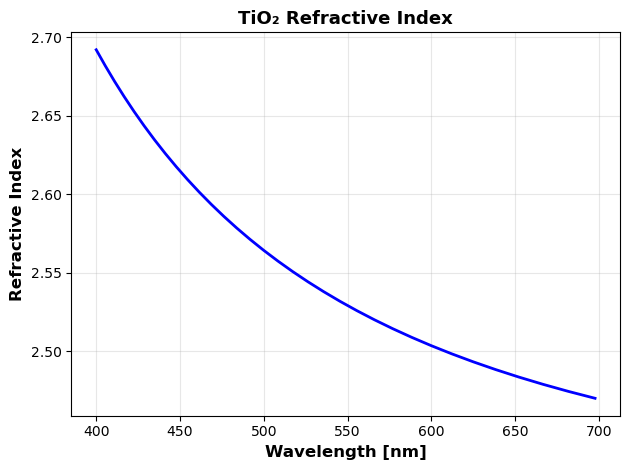

In [45]:
# Load TiO₂ wavelength-dependent permittivity data
epsilon_tio2_array = np.load('TiO2_refractive_indices_bodurov.npy')

# SiO₂ glass substrate properties (constant)
n_glass = 1.5
epsilon_glass = n_glass ** 2

# Wavelength range: visible spectrum
# λ = c/f where c = 3e14 nm/s = 3 μm·THz
frequencies_thz = np.arange(4.3, 7.6, 0.1)  # [THz]
wavelengths_um = 3 / frequencies_thz  # Convert to [μm]

print(f"Wavelength range: {wavelengths_um.min():.3f} - {wavelengths_um.max():.3f} μm")
print(f"                  ({wavelengths_um.min()*1000:.0f} - {wavelengths_um.max()*1000:.0f} nm)")
print(f"Number of wavelengths: {len(wavelengths_um)}")
print(f"TiO₂ permittivity range: ε = {epsilon_tio2_array.min():.2f} - {epsilon_tio2_array.max():.2f}\n")

# Plot TiO₂ refractive index dispersion
n_tio2 = np.sqrt(epsilon_tio2_array)
plt.plot(wavelengths_um * 1000, n_tio2, 'b-', linewidth=2)
plt.xlabel('Wavelength [nm]', fontsize=12, fontweight='bold')
plt.ylabel('Refractive Index', fontsize=12, fontweight='bold')
plt.title('TiO₂ Refractive Index', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Simulation Parameters

### Computational Settings:
- **Resolution**: 512×512 spatial grid
- **Harmonics**: 17
- **Device**: GPU (CUDA) if available, otherwise CPU

### Structure Dimensions:
- **Period**: 380 nm (both x and y)
- **Post height**: 800 nm
- **Post dimensions**: 180 nm × 100 nm (before rotation)
- **Rotation**: 45° counter-clockwise

### Illumination:
- **Normal incidence**: θ = 0°, φ = 0°
- **Polarization**: x-polarized (at normal incidence, TE is defined as x-polarized in this RCWA simulation package, amp_TE = 1.0)

In [49]:
# ========================================
# Computational Settings
# ========================================
resolution = 512      # Spatial grid resolution
n_harmonics = 17      # Number of Fourier harmonics (17×17 = 289 modes)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.complex64

# ========================================
# Structure Dimensions [μm]
# ========================================
period = 0.38            # Unit cell period (same in x and y)
grating_height = 0.8     # TiO₂ post height
rect_length = 0.18       # Rectangle length (before rotation)
rect_width = 0.1         # Rectangle width (before rotation)
rotation_angle = 45      # Rotation angle [degrees]

# ========================================
# Incident Light Parameters
# ========================================
theta_deg = 0.0     # Polar angle (normal incidence)
phi_deg = 0.0       # Azimuthal angle
amp_TE = 1.0        # TE polarization amplitude (x-polarized light, at normal incidence, TE is defined as x-polarized)

# Print summary
print("="*70)
print("SIMULATION SETUP")
print("="*70)
print(f"Computing on: {device}")
print(f"Grid resolution: {resolution} × {resolution}")
print(f"Fourier harmonics: {n_harmonics}")
print(f"\nStructure:")
print(f"  Period: {period*1000:.0f} nm")
print(f"  Post height: {grating_height*1000:.0f} nm")
print(f"  Post size: {rect_length*1000:.0f} nm × {rect_width*1000:.0f} nm @ {rotation_angle}°")
print(f"\nIllumination:")
print(f"  Angle: θ = {theta_deg}°, φ = {phi_deg}° (normal incidence)")
print(f"  Polarization: x-polarized")
print("="*70)

SIMULATION SETUP
Computing on: cuda:0
Grid resolution: 512 × 512
Fourier harmonics: 17

Structure:
  Period: 380 nm
  Post height: 800 nm
  Post size: 180 nm × 100 nm @ 45°

Illumination:
  Angle: θ = 0.0°, φ = 0.0° (normal incidence)
  Polarization: x-polarized


## Create Geometry Pattern

Create a rectangular TiO₂ post and rotate it by 45°.

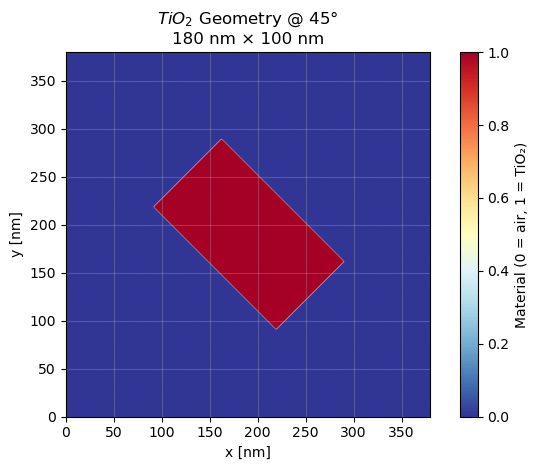

In [59]:
# Create rectangular pattern
rect = geometry.rectangle(
    resolution=resolution,
    p=period,              # Physical period for scaling
    wx=rect_length,        # Width in x direction
    wy=rect_width,         # Width in y direction
    device=device
)

# Rotate by 45 degrees (counter-clockwise from +x to +y)
pattern = geometry.rotate(rect, angle=rotation_angle)

# Visualize the pattern
plt.imshow(pattern.cpu().numpy(), cmap='RdYlBu_r', origin='lower', vmin=0, vmax=1,
           extent=[0, period*1000, 0, period*1000])  # Convert to nm
plt.title(f'$TiO_2$ Geometry @ {rotation_angle}°\n{rect_length*1000:.0f} nm × {rect_width*1000:.0f} nm', fontsize=12)
plt.xlabel('x [nm]')
plt.ylabel('y [nm]')
plt.colorbar(label='Material (0 = air, 1 = TiO₂)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Run RCWA Simulation

Sweep over wavelengths and compute transmission coefficients.

### Three-Layer Structure:
1. **Reflection region**: Air (semi-infinite)
2. **Grating layer**: TiO₂ posts in air background (finite thickness)
3. **Transmission region**: SiO₂ glass substrate (semi-infinite)

In [36]:
# Storage for results
t_xx_rcwa = torch.zeros(len(wavelengths_um), dtype=dtype, device=device)
t_xy_rcwa = torch.zeros(len(wavelengths_um), dtype=dtype, device=device)

total_start = time.time()

for i, (wavelength, epsilon_tio2) in enumerate(zip(wavelengths_um, epsilon_tio2_array)):
    # ========================================
    # Setup Environment (3-layer structure)
    # ========================================
    env = Environment(period, period, n_harmonics, resolution, device, dtype)
    
    # Layer 1: Semi-infinite air (reflection region)
    env.set_ref_layer(epsilon_r=1.0)
    
    # Layer 2: TiO₂ grating layer (finite thickness)
    #   - Material (where pattern=1): TiO₂ with wavelength-dependent ε
    #   - Background (where pattern=0): Air with ε=1.0
    env.add_layer(
        thickness=grating_height,
        epsilon_material=epsilon_tio2,   # TiO₂ permittivity (dispersive)
        epsilon_background=1.0,           # Air background
        geometry_pattern=pattern
    )
    
    # Layer 3: Semi-infinite glass substrate (transmission region)
    env.set_trn_layer(epsilon_r=epsilon_glass)
    
    # Build the layer structure
    env.build()
    
    # ========================================
    # Setup Incident Light
    # ========================================
    inc = Incident(
        lamb0=wavelength,
        Lambda_x=period,
        Lambda_y=period,
        n_harmonics=n_harmonics,
        theta=theta_deg,
        phi=phi_deg,
        amp_TE=amp_TE,  # x-polarized (TE mode)
        epsilon_ref=env._ref_layer['epsilon_r'][0],
        mu_ref=env._ref_layer['mu_r'][0],
        epsilon_trn=env._trn_layer['epsilon_r'][0],
        mu_trn=env._trn_layer['mu_r'][0],
        device=device,
        dtype=dtype
    )
    
    # ========================================
    # Solve RCWA
    # ========================================
    start = time.time()
    
    rcwa_solver = RCWA(env, inc)
    rcwa_solver.solve_S_matrix()  # Compute scattering matrix
    rcwa_solver.solve_RT()         # Compute reflection/transmission
    
    # Extract transmitted field at (0,0) diffraction order (specular transmission)
    _, t_field = rcwa_solver.field_by_order(nx=0, ny=0)
    
    # Transmission coefficients
    # t_field = [t_x, t_y, t_z] in Cartesian coordinates
    t_x = t_field[0]  # x-component (co-polarization)
    t_y = t_field[1]  # y-component (cross-polarization)
    
    # Store results
    t_xx_rcwa[i] = t_x
    t_xy_rcwa[i] = t_y
    
    end = time.time()
    
    # Progress update
    print(f"\n[{i+1}/{len(wavelengths_um)}] λ = {wavelength:.3f} μm ({wavelength*1000:.0f} nm)")
    print(f"  ε_TiO₂ = {epsilon_tio2:.4f} (n = {np.sqrt(epsilon_tio2):.3f})")
    print(f"  |t_xx| = {abs(t_x):.6f}")
    print(f"  |t_xy| = {abs(t_y):.6f}")
    print(f"  Time: {utils.format_time(end-start)} (total: {utils.format_time(end-total_start)})")

print("\n" + "="*70)
print("✓ SIMULATION COMPLETE!")
print("="*70)
print(f"Total computation time: {utils.format_time(time.time()-total_start)}")


[1/33] λ = 0.698 μm (698 nm)
  ε_TiO₂ = 6.1002 (n = 2.470)
  |t_xx| = 0.908430
  |t_xy| = 0.391320
  Time: 0.911s (total: 0.916s)

[2/33] λ = 0.682 μm (682 nm)
  ε_TiO₂ = 6.1219 (n = 2.474)
  |t_xx| = 0.890008
  |t_xy| = 0.425682
  Time: 0.769s (total: 1.688s)

[3/33] λ = 0.667 μm (667 nm)
  ε_TiO₂ = 6.1442 (n = 2.479)
  |t_xx| = 0.868761
  |t_xy| = 0.464932
  Time: 0.765s (total: 2.455s)

[4/33] λ = 0.652 μm (652 nm)
  ε_TiO₂ = 6.1673 (n = 2.483)
  |t_xx| = 0.843017
  |t_xy| = 0.510693
  Time: 0.750s (total: 3.208s)

[5/33] λ = 0.638 μm (638 nm)
  ε_TiO₂ = 6.1910 (n = 2.488)
  |t_xx| = 0.809425
  |t_xy| = 0.565176
  Time: 0.760s (total: 3.971s)

[6/33] λ = 0.625 μm (625 nm)
  ε_TiO₂ = 6.2156 (n = 2.493)
  |t_xx| = 0.765098
  |t_xy| = 0.626024
  Time: 0.761s (total: 4.735s)

[7/33] λ = 0.612 μm (612 nm)
  ε_TiO₂ = 6.2408 (n = 2.498)
  |t_xx| = 0.706294
  |t_xy| = 0.691374
  Time: 0.758s (total: 5.496s)

[8/33] λ = 0.600 μm (600 nm)
  ε_TiO₂ = 6.2669 (n = 2.503)
  |t_xx| = 0.630787
  |

## Compare with COMSOL Results

### Transmission Coefficients:
- **T_xx**: Co-polarization (x → x), light remains x-polarized
- **T_xy**: Cross-polarization (x → y), polarization rotation to y

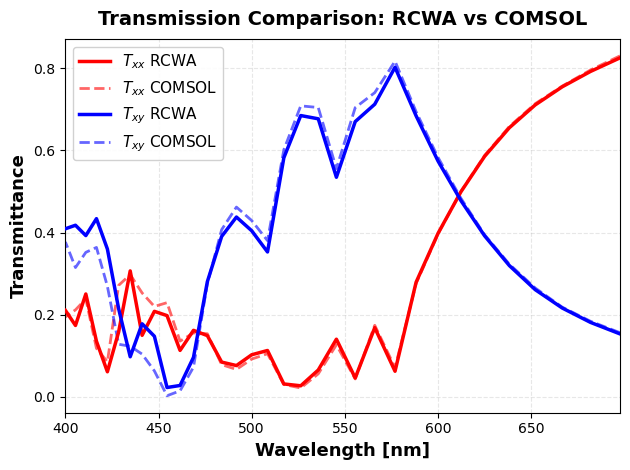

In [57]:
# Convert wavelengths to nm for better readability
wavelengths_nm = wavelengths_um * 1000

# Compute transmittance (|T|²)
T_xx_rcwa = np.abs(t_xx_rcwa.cpu().numpy())**2
T_xy_rcwa = np.abs(t_xy_rcwa.cpu().numpy())**2

# COMSOL data includes refractive index factor for power flow
T_xx_comsol = np.abs(t_xx_comsol)**2 * n_glass
T_xy_comsol = np.abs(t_xy_comsol)**2 * n_glass

# ========================================
# Create Comparison Plot
# ========================================

# Plot T_xx (co-polarization: x → x)
plt.plot(wavelengths_nm, T_xx_rcwa, 'r-', linewidth=2.5, 
         label='$T_{xx}$ RCWA', zorder=3)
plt.plot(wavelengths_nm, T_xx_comsol, 'r--', linewidth=2, 
         alpha=0.6, label='$T_{xx}$ COMSOL', zorder=2)

# Plot T_xy (cross-polarization: x → y)
plt.plot(wavelengths_nm, T_xy_rcwa, 'b-', linewidth=2.5, 
         label='$T_{xy}$ RCWA', zorder=3)
plt.plot(wavelengths_nm, T_xy_comsol, 'b--', linewidth=2, 
         alpha=0.6, label='$T_{xy}$ COMSOL', zorder=2)

plt.xlabel('Wavelength [nm]', fontsize=13, fontweight='bold')
plt.ylabel('Transmittance', fontsize=13, fontweight='bold')
plt.title('Transmission Comparison: RCWA vs COMSOL', fontsize=14, fontweight='bold', pad=10)
plt.legend(fontsize=11, loc='best', framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlim(wavelengths_nm.min(), wavelengths_nm.max())

plt.tight_layout()
plt.show()